```
Author: Naved Iqbal

Email: navediqbal5@gmail.com

GitHub: https://github.com/Naved-Iqbal/StockTrading.git
```

## **Momentum Scanner**

This code analyzes a list of stocks from the Indian stock market (NSE) and ranks them based on their momentum over various periods (6 months, 3 months, and 1 month). It uses technical indicators such as Exponential Moving Averages (EMAs) and Relative Strength Index (RSI) to identify stocks with strong upward trends and potential for future growth. The code generates a table visualizing the top-ranked stocks based on their momentum scores. You can also save the result in to Google drive in MS-Excel format.

---

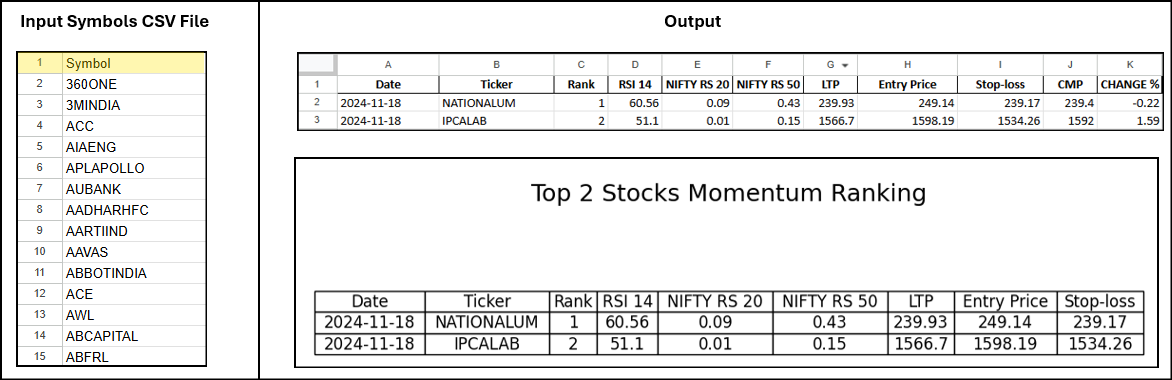

**Import Necessary Libraries**

Import libraries for financial analysis, data handling, and visualization.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import pytz
import matplotlib.pyplot as plt
from matplotlib.table import Table
from google.colab import drive, files
import ipywidgets as widgets


**Configuration**

Set parameters for data sources, momentum calculation, technical indicators, and stock selection criteria.

In [2]:
# Adjust layout to increase width
layout = widgets.Layout(width='50%')
style = {'description_width': 'initial'}


# # Add end date pickers
# today_date_obj = datetime.today()

ist_timezone = pytz.timezone('Asia/Kolkata')
today_date_obj = datetime.now(ist_timezone)

end_date_picker = widgets.DatePicker(
    value = today_date_obj,
    description='Stock Data Till:',
    disabled=False,
    layout = layout,
    style = style
)

# Create a label
label = widgets.Label(value="Upload Input Symbols CSV file:")

input_symbols_file = widgets.FileUpload(
    disabled=False,
    accept='.csv',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

minimum_stock_price = widgets.IntText(
    value=50,
    description='Minimum Stock Price:',
    disabled=False,
    min=1,
    layout = layout,
    style = style
)

short_term_period = widgets.IntText(
    value=21,
    description='Short-Term Period (Candles):',
    disabled=False,
    min=1,
    layout = layout,
    style = style
)

medium_term_period = widgets.IntText(
    value=63,
    description='Medium-Term Period (Candles):',
    disabled=False,
    min=1,
    layout = layout,
    style = style
)

long_term_period = widgets.IntText(
    value=126,
    description='Long-Term Period (Candles):',
    disabled=False,
    min=1,
    layout = layout,
    style = style
)

rsi_period = widgets.IntText(
    value=14,
    description='RSI Period:',
    disabled=False,
    min=1,
    max=100,
    layout = layout,
    style = style
)

short_term_rs_period = widgets.IntText(
    value=20,
    description='Short-Term RS Period:',
    disabled=False,
    min=1,
    layout = layout,
    style = style
)

medium_term_rs_period = widgets.IntText(
    value=50,
    description='Medium-Term RS Period:',
    disabled=False,
    min=1,
    layout = layout,
    style = style
)

minimum_one_year_return = widgets.IntText(
    value=7,
    description='Minimum One-Year Return (%):',
    disabled=False,
    min=1,
    max=100,
    layout = layout,
    style = style
)

within_52_weeks_high_pct = widgets.IntText(
    value=25,
    description='Within 52 Weeks High (%):',
    disabled=False,
    min=1,
    max=100,
    layout = layout,
    style = style
)

minumun_up_days_pct = widgets.IntText(
    value=45,
    description='Minimum Up Days (%):',
    disabled=False,
    min=1,
    max=100,
    layout = layout,
    style = style
)




# Display the widgets
display(widgets.HBox([label, input_symbols_file]), end_date_picker, minimum_stock_price,
        short_term_period, medium_term_period, long_term_period, rsi_period,
        short_term_rs_period, medium_term_rs_period, minimum_one_year_return, within_52_weeks_high_pct, minumun_up_days_pct)

DatePicker(value=datetime.datetime(2024, 11, 19, 13, 47, 59, 478346, tzinfo=<DstTzInfo 'Asia/Kolkata' IST+5:30…

IntText(value=50, description='Minimum Stock Price:', layout=Layout(width='50%'), style=DescriptionStyle(descr…

IntText(value=21, description='Short-Term Period (Candles):', layout=Layout(width='50%'), style=DescriptionSty…

IntText(value=63, description='Medium-Term Period (Candles):', layout=Layout(width='50%'), style=DescriptionSt…

IntText(value=126, description='Long-Term Period (Candles):', layout=Layout(width='50%'), style=DescriptionSty…

IntText(value=14, description='RSI Period:', layout=Layout(width='50%'), style=DescriptionStyle(description_wi…

IntText(value=20, description='Short-Term RS Period:', layout=Layout(width='50%'), style=DescriptionStyle(desc…

IntText(value=50, description='Medium-Term RS Period:', layout=Layout(width='50%'), style=DescriptionStyle(des…

IntText(value=7, description='Minimum One-Year Return (%):', layout=Layout(width='50%'), style=DescriptionStyl…

IntText(value=25, description='Within 52 Weeks High (%):', layout=Layout(width='50%'), style=DescriptionStyle(…

IntText(value=45, description='Minimum Up Days (%):', layout=Layout(width='50%'), style=DescriptionStyle(descr…

**Load Stock Symbols**

Mount Google Drive to access a list of Indian stock symbols from a CSV file.

The commented out code represents an alternative way to define the stock symbols manually, instead of reading them from a CSV file.

In [13]:
column_name = 'Symbol'
symbols_df = pd.DataFrame()
tickers = []

try:

  if input_symbols_file.value:

    uploaded_file = list(input_symbols_file.value.values())[0]

    symbols_df = pd.read_csv(pd.io.common.BytesIO(uploaded_file['content']))

    uploaded_file_name = uploaded_file['metadata']['name']

    # Check if column is present
    if column_name in symbols_df.columns:
      now_of_rows = symbols_df.shape[0]
      if now_of_rows > 0:
        symbols_df['Ticker'] = symbols_df[column_name]+'.NS'
        tickers = symbols_df['Ticker'].tolist()
        print(f"Loaded {now_of_rows} Stock symbols successfully.")
      else:
        print(f"The uploaded file '{uploaded_file_name}' has no symbols!")

    else:
      print(f"Column '{column_name}' is missing in the uploaded file '{uploaded_file_name}'")

  else:
    print("Please upload input symbols (.csv) file!")

except Exception as e1:
    print("Error loading symbols! Please check if uploaded csv file is correct or not.\n")
    print(e1)

Loaded 400 Stock symbols successfully.


**Downloads daily historical data for stocks and index**


In [14]:
# Data dictionary to hold stock data
daily_data = None
index_data = None
stocks_data = {}

daily_data_interval = "1d"
till_date_with_timezone = None

# Parse date string into a datetime object
till_date_str = (end_date_picker.value).strftime("%Y-%m-%d")
till_date_time_obj = datetime.strptime(till_date_str, '%Y-%m-%d')

# Get current (todays) date
current_date_str = datetime.now(ist_timezone).strftime("%Y-%m-%d")
current_date_obj = datetime.strptime(current_date_str, '%Y-%m-%d').date()
till_date_obj = datetime.strptime(till_date_str, '%Y-%m-%d').date()

# Check if the given date is today or in the past
if till_date_obj <= current_date_obj:



    # If selected date is current (todays) date, then add current datetime to it
    if till_date_str == current_date_str:

      # Combine with current time
      till_date_with_timezone = datetime.now(ist_timezone)
    else:

      # Define constant time to add (e.g., 5 hours, 30 minutes, 15 seconds)
      constant_time = timedelta(hours=22, minutes=00, seconds=00)

      till_date_with_timezone = ist_timezone.localize(till_date_time_obj + constant_time)

    from_date_with_timezone = ist_timezone.localize(till_date_time_obj - timedelta(days=365 * 2))

    print(f"Downloading Daily Time Frame Data:")
    print(f"From: {from_date_with_timezone}")
    print(f"Till: {till_date_with_timezone}\n")


    print(f"Downloading Data for NIFTY50 Index:")
    index_data = yf.download(
      tickers="^NSEI",
      start=from_date_with_timezone,
      end=till_date_with_timezone,
      interval=daily_data_interval)


    # Split tickers into batches of 300
    batch_size = 300
    ticker_batches =  [tickers[i:i + batch_size] for i in range(0, len(tickers), batch_size)]

    print(f"\n\nDownloading Data for {len(tickers)} Stocks in Batches | (Batch Size: {batch_size})")


    for i, batch in enumerate(ticker_batches, 1):
        print(f"\nBatch {i}: {len(batch)} tickers")

        daily_data = yf.download(
            tickers=batch,
            threads=True,
            group_by='ticker',
            start=from_date_with_timezone,
            end=till_date_with_timezone,
            interval="1d",
            timeout=15,
            auto_adjust=False
          )


        for ticker in batch:
            stocks_data[ticker] = daily_data[ticker].copy()


        if i != len(ticker_batches):
          # Wait 10 seconds
          time.sleep(10)


    # daily_data = yf.download(
    #     tickers=,
    #     threads=True,
    #     group_by='ticker',
    #     period=None,
    #     start=from_date_with_timezone,
    #     end= till_date_with_timezone,
    #     interval=daily_data_interval)

else:
    print(f"{till_date_str} | Till date should not be future date.")

[*********************100%***********************]  1 of 1 completed

From: 2022-11-15 00:00:00+05:30
Till: 2024-11-14 22:00:00+05:30




Batch 1: 300 tickers



[*********************100%***********************]  300 of 300 completed
[                       0%                       ]


Batch 2: 100 tickers


[*********************100%***********************]  100 of 100 completed


**Calculate Relative Strength Index (RSI)**

Calculate the Relative Strength Index (RSI) for a stock's price data.

In [15]:
def calculate_rsi(df, period):

    delta = df["Close"].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    _gain = up.ewm(com=(period - 1), min_periods=period).mean()
    _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()
    RS = _gain / _loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

**Calculate Relative Strength (RS)**

Calculate Relative Strength of a stock against a market index (NIFTY50) over a specified period.

In [16]:
def calculate_rs(stock_data, index_data, length):
  # Truncate both DataFrames to the minimum length
  stock_data = stock_data.tail(length+5).copy()
  index_data = index_data.tail(length+5).copy()

  # Reset the index
  stock_data = stock_data.reset_index(drop=True)
  index_data = index_data.reset_index(drop=True)

  # Calculate percentage change over the specified period
  stock_data['Return'] = stock_data['Close'].pct_change(periods=length)
  index_data['Return'] = index_data['Close'].pct_change(periods=length)

  # Calculate Relative Strength
  rs = round(stock_data['Return']  - index_data['Return'], 2)

  return rs

**Stock Filtering and Analysis**

Filter the stocks using conditions:


*   Stock should not be new, should be listed at least 6 months ago
*   SMA (Stock Price Should be above key Moving Averages 50, 150, 200)
*   RSI should be greater than 50 and less than 70
*   Volume (20-days average volume should be be greater than or equal to 100000)
*   Last one year return should be greater than 7-8% (FD Return)
*   Within 20% or 25% from 52-Week High
*   Up Days (Green Candles) Percentage should be greater than 45%


In [17]:
# Create a DataFrame for summary
summary = []

pct_multiplier = round((100 - within_52_weeks_high_pct.value) / 100, 2)

long_term_period_label = f'{long_term_period.value}D'
medium_term_period_label = f'{medium_term_period.value}D'
short_term_period_label = f'{short_term_period.value}D'

long_term_return_label = f'Return {long_term_period_label}'
medium_term_return_label = f'Return {medium_term_period_label}'
short_term_return_label = f'Return {short_term_period_label}'

long_term_rank_label = f'Rank {long_term_period_label}'
medium_term_rank_label = f'Rank {medium_term_period_label}'
short_term_rank_label = f'Rank {short_term_period_label}'

RSI_label = f'RSI {rsi_period.value}'
Short_Term_RS_label = f'NIFTY RS {short_term_rs_period.value}'
Medium_Term_RS_label = f'NIFTY RS {medium_term_rs_period.value}'

row_counter = 0

for ticker in symbols_df['Ticker'].tolist():

    df = stocks_data[ticker].copy()
    symbol = ticker.replace(".NS", "")
    df.dropna(inplace=True)

    # No. of candles in stock data
    no_of_rows = df.shape[0]

    # If stock data is less than six months (126 candles)
    if df.empty or no_of_rows < 126:
        continue

    sma_condition = False
    last_one_year_return_condition = False
    within_pct_52_week_high_condition = False
    up_days_pct_condition = False

    try:

        # Latest and previous close price
        latest_close_price = round(df['Close'].iloc[-1], 2)
        previous_day_high_price = round(df['High'].iloc[-2], 2)


        # Check last one year return condition and 52-Weeks High Condition
        if no_of_rows >= 252:
            # 52-week high

            high_52_week = round((df['High'][-252:]).max(), 2)
            within_pct_52_week_high_condition = latest_close_price >= high_52_week * pct_multiplier

            #one_year_return = round((latest_close_price / df['Close'].iloc[-252] - 1) * 100, 2)
            one_year_return = round(((latest_close_price - df['Close'].iloc[-252]) / df['Close'].iloc[-251]) * 100, 2)


            # Last one year return condition
            last_one_year_return_condition = one_year_return >= minimum_one_year_return.value


        # If stock data is less than a year, return since stock is listed
        else:
            # 52-week high
            high_52_week = round((df['High'][-no_of_rows:]).max(), 2)
            within_pct_52_week_high_condition = latest_close_price >= high_52_week * pct_multiplier

            # Last one year return
            # one_year_return = round((latest_close_price/ df['Close'].iloc[-no_of_rows] - 1) * 100, 2)
            one_year_return = round(((latest_close_price - df['Close'].iloc[-no_of_rows]) / df['Close'].iloc[-no_of_rows+1]) * 100, 2)

             # Last one year return condition
            last_one_year_return_condition = one_year_return >= minimum_one_year_return.value



        # Calculate SMA
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Close'].rolling(window=50).mean()

        latest_sma_20 = round(df['SMA_20'].iloc[-1], 2)
        latest_sma_50 = round(df['SMA_50'].iloc[-1], 2)

        # Calculate EMA-200, 52 Weeks High and one year return
        if no_of_rows >= 200:

            #df['EMA_200'] = df['Close'].ewm(span=200).mean()
            df['SMA_150'] = df['Close'].rolling(window=150).mean()
            df['SMA_200'] = df['Close'].rolling(window=200).mean()

            latest_sma_150 = round(df['SMA_150'].iloc[-1], 2)
            latest_sma_200 = round(df['SMA_200'].iloc[-1], 2)

            # SMA condition
            sma_condition = latest_close_price >= latest_sma_50 and\
                            latest_sma_20 > latest_sma_50 and\
                            latest_sma_50 > latest_sma_150 and\
                            latest_sma_150 > latest_sma_200

        elif no_of_rows >= 150:

            df['SMA_150'] = df['Close'].rolling(window=150).mean()

            latest_sma_150 = round(df['SMA_150'].iloc[-1], 2)

            # SMA condition
            sma_condition = latest_close_price >= latest_sma_50 and\
                            latest_sma_20 > latest_sma_50 and\
                            latest_sma_50 > latest_sma_150

        else:

            # SMA condition
            sma_condition = latest_close_price >= latest_sma_50 and\
                            latest_sma_20 > latest_sma_50


        # More than 45% up days in the last 6 months (126 trading days)
        long_term_data = df['Close'].iloc[-long_term_period.value:]

        up_days = (long_term_data.pct_change() > 0).sum()
        up_days_pct = up_days / len(long_term_data) * 100

        up_days_pct_condition = up_days_pct > minumun_up_days_pct.value


        # Calculate RSI (Relative Strength Index)
        df['RSI'] = calculate_rsi(df, rsi_period.value)
        daily_rsi = round(df['RSI'].iloc[-1], 2)


        rsi_condition = daily_rsi > 50 and daily_rsi < 70


        # Latest Volume
        latest_volume = round(df['Volume'].iloc[-1], 2)


        # 20-Day Avergae Volume
        df['Volume_SMA_20'] = df['Volume'].rolling(window=20).mean()
        daily_average_volume = round(df['Volume_SMA_20'].iloc[-1], 2)

        volume_condition = latest_volume > daily_average_volume and daily_average_volume >= 100000


        # latest_close_price > latest_open_price
        # Filtering criteria
        if (
            latest_close_price >= minimum_stock_price.value and
            latest_close_price > previous_day_high_price and
            volume_condition and
            sma_condition and
            last_one_year_return_condition and
            within_pct_52_week_high_condition and
            up_days_pct_condition and
            rsi_condition):

            # Calculate returns
            long_term_return = round(((df['Close'].iloc[-1] - df['Close'].iloc[-(long_term_period.value+1)]) / df['Close'].iloc[-(long_term_period.value+1)]) * 100, 2)
            medium_term_return = round(((df['Close'].iloc[-1] - df['Close'].iloc[-(medium_term_period.value+1)]) /  df['Close'].iloc[-(medium_term_period.value+1)]) * 100, 2)
            short_term_return = round(((df['Close'].iloc[-1] - df['Close'].iloc[-(short_term_period.value+1)]) / df['Close'].iloc[-(short_term_period.value+1)]) * 100, 2)

            # Calculate RS (Relative Strength)
            short_term_rs = calculate_rs(df, index_data, short_term_rs_period.value)
            daily_short_term_rs = short_term_rs.iloc[-1]

            medium_term_rs = calculate_rs(df, index_data, medium_term_rs_period.value)
            daily_medium_term_rs = medium_term_rs.iloc[-1]


            last_candle_date = df.index[-1].date().strftime("%Y-%m-%d")

            # <=500	0.50%	0.005
            # >500 and <= 1000	0.30%	0.003
            # > 1000	0.20%	0.002

            entry_offset_percentage = 0
            if latest_close_price <= 500:
                entry_offset_percentage = 0.005

            elif latest_close_price > 500 and latest_close_price <= 1000:
                entry_offset_percentage = 0.003

            elif latest_close_price > 1000:
                entry_offset_percentage = 0.002


            last_candle_high = round(df['High'].iloc[-1], 2)
            entry_price_offset_value = round(last_candle_high * entry_offset_percentage, 2)
            entry_price = round(last_candle_high + (entry_price_offset_value), 2)
            stop_loss = round( entry_price - (entry_price*0.04), 2)

            summary.append({
                'Date': last_candle_date,
                'Ticker': symbol,
                long_term_return_label: long_term_return,
                medium_term_return_label: medium_term_return,
                short_term_return_label: short_term_return,
                RSI_label: daily_rsi,
                Short_Term_RS_label: daily_short_term_rs,
                Medium_Term_RS_label:  daily_medium_term_rs,
                "LTP": latest_close_price,
                "Entry Price": entry_price,
                "Stop-loss": stop_loss
            })

            row_counter += 1
    except Exception as e:
        print(f"Error analyzing {symbol}: {e}")


**Ranks stocks by momentum, select top performers**

In [18]:
# Convert summary to DataFrame
df_summary = pd.DataFrame(summary)

df_summary[long_term_rank_label] = df_summary[long_term_return_label].rank(ascending=False, method='dense')
df_summary[medium_term_rank_label] = df_summary[medium_term_return_label].rank(ascending=False, method='dense')
df_summary[short_term_rank_label] = df_summary[short_term_return_label].rank(ascending=False, method='dense')


# Calculate final rank
df_summary['Cumulative_Rank'] = (df_summary[long_term_rank_label] + df_summary[medium_term_rank_label] + df_summary[short_term_rank_label])/3

all_periods_label = f'{long_term_period_label}, {medium_term_period_label}, {short_term_period_label}'
all_returns_label = f'Returns ({all_periods_label})'
all_ranks_label = f'Ranks ({all_periods_label})'

# Sort by final rank and get top 40
df_summary_sorted = df_summary.sort_values('Cumulative_Rank').head(40)
df_summary_sorted = df_summary_sorted.drop(columns=['Cumulative_Rank', long_term_return_label, medium_term_return_label, short_term_return_label, long_term_rank_label, medium_term_rank_label, short_term_rank_label])

# Assign position based on final rank
# Arguments: position (index), column name, values
#df_summary_sorted['Rank'] = np.arange(1, len(df_summary_sorted) + 1)
df_summary_sorted.insert(2, "Rank", np.arange(1, len(df_summary_sorted) + 1))
df_summary_sorted.reset_index(drop=True, inplace=True)



**Visualizes the top stock rankings using a table and highlights the top 20 stocks**

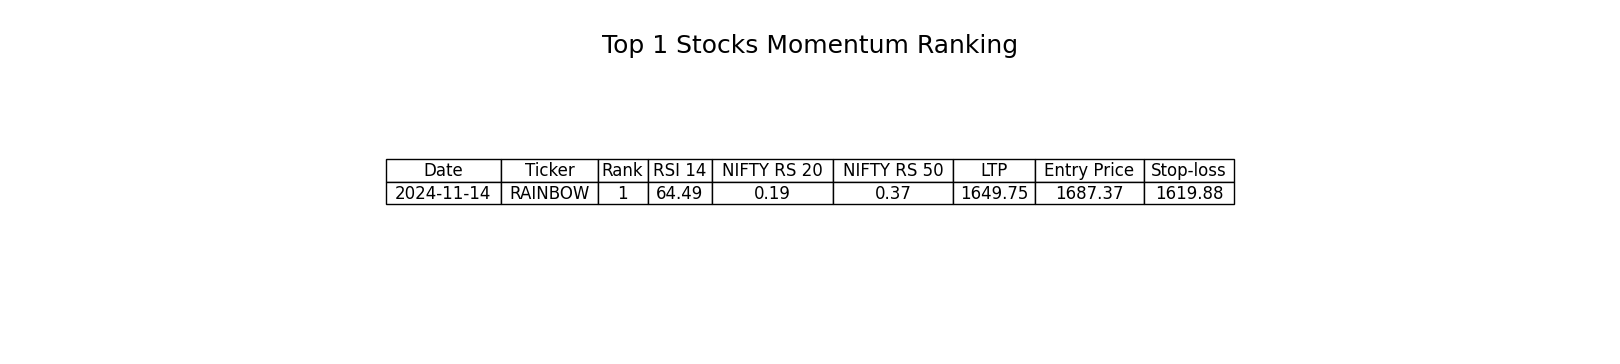

In [19]:
# Prepare table data
tbl_data = []
for i, row in df_summary_sorted.iterrows():
    # row[all_returns_label], row[all_ranks_label]

    tbl_data.append([
        row['Date'],
        row['Ticker'],
        row['Rank'],
        row[RSI_label],
        row[Short_Term_RS_label],
        row[Medium_Term_RS_label],
        row['LTP'],
        row['Entry Price'],
        row['Stop-loss']
    ])

no_of_selected_stocks = len(tbl_data)
# Plot the results using matplotlib
fig, ax = plt.subplots(figsize=(20, 5))
# fig, ax = plt.subplots(figsize=(20, 13))
ax.axis('tight')
ax.axis('off')

# Create a table
col_labels = ['Date',
              'Ticker',
              'Rank',
              RSI_label,
              Short_Term_RS_label,
              Medium_Term_RS_label,
              'LTP',
              'Entry Price',
              'Stop-loss'
             ]

table = ax.table(cellText=tbl_data, colLabels=col_labels, cellLoc='center', loc='center')
table.auto_set_column_width(col=list(range(len(col_labels))))  # Auto-adjust column width
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

if no_of_selected_stocks > 20:
  # Draw a red line to separate the top 15
  for i in range(len(col_labels)):
      cell = table[(20, i)]
      cell.set_edgecolor('red')
      cell.set_linewidth(3)

# Adjust layout
plt.subplots_adjust(left=0.1, top=0.8)  # Adjust top parameter for title position

# ({till_date_str})
plt.title(f'Top {no_of_selected_stocks} Stocks Momentum Ranking', fontsize=18, y=0.85)  # y parameter for title position
plt.show()

**Save the stock rankings to an Excel file on Google Drive.**

In [20]:
# save table in Excel file in Google drive
df_summary_sorted['CMP'] = df_summary_sorted.apply(lambda row: f'=GOOGLEFINANCE("NSE:"&B{row.name+2}, "price")', axis=1)
df_summary_sorted['CHANGE %'] = df_summary_sorted.apply(lambda row: f'=ROUND((J{row.name+2} - G{row.name+2}) / J{row.name+2} * 100, 2)', axis=1)

# save table in Excel file in Google drive
current_datetime_ist = datetime.now(ist_timezone)
date_string = current_datetime_ist.strftime("%d_%b_%Y_%I_%M_%p")

output_file_path = f'momentum_scan_{long_term_period_label}_{medium_term_period_label}_{short_term_period_label}_{date_string}.xlsx'

# Assuming 'df_summary_sorted' is your DataFrame
df_summary_sorted.to_excel(output_file_path, index=False)

# If you want to download the file locally as well, you can uncomment the following line:
files.download(output_file_path)
print("Excel file downloaded successfully.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Excel file downloaded successfully.
